In [1]:
import jax
import jax.numpy as np

from numpy.polynomial.hermite import hermgauss

from structure_vb_lib import structure_model_lib, posterior_quantities_lib, data_utils, plotting_utils
import structure_vb_lib.structure_optimization_lib as s_optim_lib

from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation
from bnpmodeling_runjingdev.bnp_optimization_lib import optimize_kl
from bnpmodeling_runjingdev import influence_lib, cluster_quantities_lib, result_loading_utils
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
seed = 98765
onp.random.seed(seed)

In [3]:
save_data = False
out_datadir = '/scratch/users/genomic_times_series_bnp/bnp_sensitivity_paper_data/structure/'

# Load data

In [4]:
g_obs, _, labels, _ = data_utils.load_thrush_data()

loading thrush data from : 
../data/thrush_data/thrush-data.str


In [5]:
print(g_obs.shape)

(155, 7, 2, 21)


In [6]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_allele = g_obs.shape[-1]

In [7]:
onp.unique(labels)

array(['Chawia', 'Mbololo', 'Ngangao', 'Yale'], dtype='<U32')

# Get prior

In [8]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params(n_allele)

alpha0 = 3.0
prior_params_dict['dp_prior_alpha'] = alpha0

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': 3.0, 'allele_prior_lambda_vec': DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1.], dtype=float64)}


# Get VB params 

In [9]:
k_approx = 20

In [10]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [11]:
vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs = n_obs,
                                                      n_loci = n_loci,
                                                      n_allele = n_allele, 
                                                      k_approx = k_approx, 
                                                      prng_key = jax.random.PRNGKey(seed))
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_dirichlet_params] = NumericArrayPattern (20, 7, 21) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (155, 19) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (155, 19) (lb=0.0001, ub=inf)


# Optimize

In [12]:
load_saved_fit = True
if load_saved_fit: 
    vb_opt_dict, _, init_fit_metadata = \
        paragami.load_folded('../fits/main_fits/structure_initial_fit.npz')
    
    vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)
    
    # optimal z
    ez_opt = posterior_quantities_lib.get_optimal_z_from_vb_dict(g_obs, vb_opt_dict, gh_loc, gh_weights)
    
    # check model matches
    kl = structure_model_lib.get_kl(g_obs, 
                           vb_opt_dict, 
                           prior_params_dict, 
                           gh_loc, 
                           gh_weights)
    
    assert init_fit_metadata['alpha0'] == alpha0 
    assert np.abs(init_fit_metadata['final_kl'] - kl) < 1e-10
    
else: 
    vb_params_dict = s_optim_lib.initialize_structure(g_obs, 
                                                  vb_params_dict, 
                                                  vb_params_paragami,
                                                  prior_params_dict, 
                                                  gh_loc, 
                                                  gh_weights, 
                                                  seed = seed)
    
    
    vb_opt_dict, vb_opt, ez_opt, out, _ = \
        s_optim_lib.optimize_structure(g_obs,
                                       vb_params_dict,
                                       vb_params_paragami,
                                       prior_params_dict, 
                                       gh_loc, 
                                       gh_weights)

# At the optimum, define the sensitivity object

In [13]:
def objective_fun(vb_params_free, epsilon): 
    
    # this actually does not depend on epsilon! 
    # we will set the perturbation later
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return structure_model_lib.get_kl(g_obs, 
                                      vb_params_dict,
                                      prior_params_dict,
                                      gh_loc, 
                                      gh_weights).squeeze()

In [14]:
# Define the linear sensitivity class
vb_sens = HyperparameterSensitivityLinearApproximation(
                    objective_fun = objective_fun, 
                    opt_par_value = vb_opt, 
                    hyper_par_value0 = np.array([0.]),
                    # null for now. will set later
                    hyper_par_objective_fun = lambda x, y: 0.)


Compiling hessian solver ...
Hessian solver compile time: 73.3199sec

Compiling cross hessian...
Cross-hessian compile time: 0.0494156sec

LR sensitivity time: 0.0302773sec



# Define perturbation

In [15]:
import jax.scipy as sp

In [16]:
def gaussian_pert(x, loc, scale): 
    return sp.stats.norm.pdf(x, loc, scale) * np.sqrt(2 * np.pi) * scale

In [17]:
log_phi = lambda x : 2 * jax.nn.sigmoid(- x) - 1

f_obj = func_sens_lib.FunctionalPerturbationObjective(log_phi, 
                                                      vb_params_paragami, 
                                                      gh_loc = gh_loc, 
                                                      gh_weights = gh_weights, 
                                                      stick_key = 'ind_admix_params', 
                                                      delta = 5)

In [18]:
# set up prior perturbation class for plotting
prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = f_obj.log_phi, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.735899e-07
  warnings.warn(


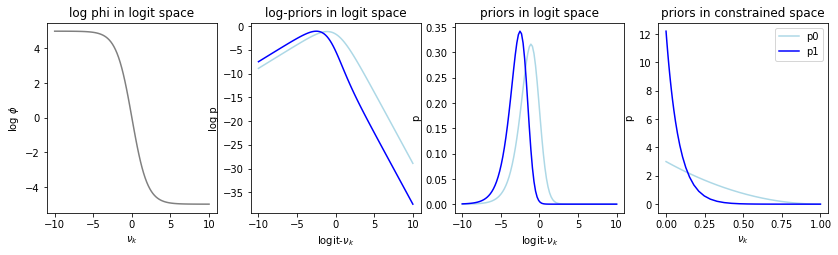

In [19]:
prior_perturbation.plot_perturbation()

# Get linear response predictions

In [20]:
epsilon_vec = np.linspace(0, 1., 5) 
print(epsilon_vec)

[0.   0.25 0.5  0.75 1.  ]


In [21]:
# set LR sensitivity class
vb_sens._set_cross_hess_and_solve(f_obj.hyper_par_objective_fun)

Compiling cross hessian...
Cross-hessian compile time: 0.4017sec

LR sensitivity time: 0.273203sec



In [22]:
hess_solve_time = vb_sens.lr_time

In [23]:
# compile for consistent timings
_ = vb_sens.predict_opt_par_from_hyper_par(epsilon_vec[0]).block_until_ready()

lr_list = []
lr_time_vec = []

for epsilon in epsilon_vec: 
        
    # get linear response
    t0 = time.time()
    lr_free_params = vb_sens.predict_opt_par_from_hyper_par(epsilon).block_until_ready()
    elapsed = time.time() - t0
    
    lr_list.append(lr_free_params)
    lr_time_vec.append(elapsed)
    
lr_time_vec = onp.array(lr_time_vec)

In [24]:
print(lr_time_vec)

[0.0010252  0.00095534 0.0010097  0.00097537 0.00104856]


# Fit for a range of epsilon

In [25]:
def get_loss(vb_params_free, epsilon): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    # get perturbation 
    e_log_phi = lambda means, infos : f_obj.e_log_phi_epsilon(means, infos, epsilon)
    
    # now add the dependence on epsilon
    return structure_model_lib.get_kl(g_obs, 
                                      vb_params_dict,
                                      prior_params_dict,
                                      gh_loc, 
                                      gh_weights, 
                                      e_log_phi = e_log_phi).squeeze()

In [26]:
get_fun = jax.jit(get_loss)

get_grad = jax.jit(jax.grad(get_loss, argnums = 0))

def _get_hvp(x, hyper_param0, v):
    return jax.jvp(jax.grad(get_loss, argnums = 0), (x, hyper_param0), (v, 0.))[1]

get_hvp = jax.jit(_get_hvp)

In [27]:
def refit_with_epsilon(epsilon, new_init_dict):
    
    _, vb_opt_pert, _, optim_time = \
        optimize_kl(lambda x : get_fun(x, epsilon),
                             new_init_dict, 
                             vb_params_paragami, 
                             get_grad = lambda x : get_grad(x, epsilon),
                             get_hvp = lambda x, v: get_hvp(x, epsilon, v),
                             run_lbfgs = False,
                             run_newton = True)                           

    return vb_opt_pert, optim_time

In [28]:
refit_list = []
refit_time_vec = []

new_init_dict = deepcopy(vb_opt_dict)

i = 0
for epsilon in epsilon_vec: 
    
    print('\n################')
    print('re-optimzing with epsilon = ', epsilon)
    print('################')
        
    refit_free, optim_time = refit_with_epsilon(epsilon, new_init_dict)
    
    refit_list.append(refit_free)
    refit_time_vec.append(optim_time)
    
refit_time_vec = onp.array(refit_time_vec)



################
re-optimzing with epsilon =  0.0
################
compiling objective and derivatives ... 
done. Compile time: 34.572sec
Running trust-ncg ... 
Newton time: 0.031sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.25
################
compiling objective and derivatives ... 
done. Compile time: 4.194sec
Running trust-ncg ... 
Newton time: 6.490sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.5
################
compiling objective and derivatives ... 
done. Compile time: 4.184sec
Running trust-ncg ... 
Newton time: 5.947sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing with epsilon =  0.75
################
compiling objective and derivatives ... 
done. Compile time: 4.197sec
Running trust-ncg ... 
Newton time: 6.399sec
Newton out:  Optimization terminated successfully.
done. 

################
re-optimzing wi

In [29]:
def get_stick_locs(vb_params_free): 
    
    # get dictionary
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    # get sticks from these individual 
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return stick_means


In [30]:
def get_stick_infos(vb_params_free): 
    
    # get dictionary
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    # get sticks from these individual 
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    return stick_infos


In [31]:
from bnpmodeling_runjingdev import stick_integration_lib

In [32]:
def get_e_sticks(vb_params_free): 
    
    # get dictionary
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    # get sticks from these individual 
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    e_sticks = stick_integration_lib.get_e_logitnormal(
                        stick_means, 
                        stick_infos,
                        gh_loc,
                        gh_weights)
    return e_sticks


In [33]:
def get_e_ind_admix(vb_params_free): 
    
    # get dictionary
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    # get sticks from these individual 
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                        stick_means, 
                        stick_infos,
                        gh_loc,
                        gh_weights)
    return e_ind_admix


In [34]:
# n = onp.random.choice(g_obs.shape[0])
n = 46

In [35]:
# fig, axarr = plt.subplots(1, 6, figsize = (20, 4), sharey = False)

# for i in range(6): 
#     axarr[i].set_title('Cluster {}'.format(i))
    
#     result_loading_utils.plot_post_stat_per_epsilon(lambda x : get_stick_means(x)[n, i],
#                                                     refit_list,
#                                                     lr_list,
#                                                     epsilon_vec, 
#                                                     axarr[i])
    
#     axarr[i].axvline(0, linestyle = '--', color = 'red')
    
# axarr[0].set_ylabel('stick means')
# axarr[0].legend()
# fig.tight_layout();

In [36]:
# fig, axarr = plt.subplots(1, 6, figsize = (20, 4), sharey = False)

# for i in range(6): 
#     axarr[i].set_title('Cluster {}'.format(i))
    
#     result_loading_utils.plot_post_stat_per_epsilon(lambda x : get_stick_infos(x)[n, i],
#                                                     refit_list,
#                                                     lr_list,
#                                                     epsilon_vec, 
#                                                     axarr[i])
    
#     axarr[i].axvline(0, linestyle = '--', color = 'red')
    
# axarr[0].set_ylabel('stick info')
# axarr[0].legend()
# fig.tight_layout();

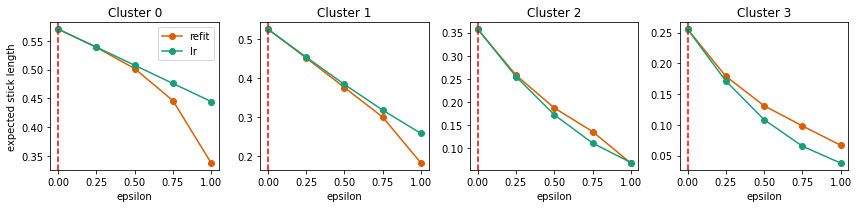

In [41]:
fig, axarr = plt.subplots(1, 4, figsize = (12, 3), sharey = False)

for i in range(4): 
    axarr[i].set_title('Cluster {}'.format(i))
    
    result_loading_utils.plot_post_stat_per_epsilon(lambda x : get_e_sticks(x)[n, i],
                                                    refit_list,
                                                    lr_list,
                                                    epsilon_vec, 
                                                    axarr[i])
    
    axarr[i].axvline(0, linestyle = '--', color = 'red')
    
axarr[0].set_ylabel('expected stick length')
axarr[0].legend()
fig.tight_layout();

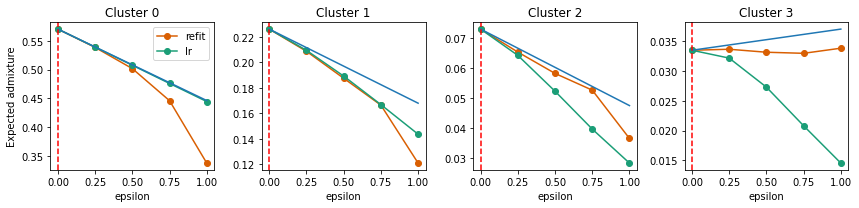

In [42]:
fig, axarr = plt.subplots(1, 4, figsize = (12, 3), sharey = False)

for i in range(4): 
    axarr[i].set_title('Cluster {}'.format(i))
    
    g = lambda x : get_e_ind_admix(x)[n, i]
    
    grad_g = jax.jacobian(g)(vb_opt)
    
    dg_dinput = (grad_g * vb_sens.dinput_dhyper.squeeze()).sum()
    
    result_loading_utils.plot_post_stat_per_epsilon(g,
                                                    refit_list,
                                                    lr_list,
                                                    epsilon_vec, 
                                                    axarr[i])
    
    axarr[i].plot(epsilon_vec, 
                  g(vb_opt) + dg_dinput * epsilon_vec)
    
    axarr[i].axvline(0, linestyle = '--', color = 'red')
    
axarr[0].set_ylabel('Expected admixture')
axarr[0].legend()
fig.tight_layout();